In [1]:
# Loading Dataset
import pandas as pd
import seaborn as sns
df = sns.load_dataset('titanic').drop(columns=['parch', 'deck', 'alive'])
df.head()

,survived,pclass,sex,age,sibsp,fare,embarked,class,who,adult_male,embark_town,alone
0,0,3,male,22.0,1,7.2500,S,Third,man,True,Southampton,False
1,1,1,female,38.0,1,71.2833,C,First,woman,False,Cherbourg,False
2,1,3,female,26.0,0,7.9250,S,Third,woman,False,Southampton,True
3,1,1,female,35.0,1,53.1000,S,First,woman,False,Southampton,False
4,0,3,male,35.0,0,8.0500,S,Third,man,True,Southampton,True


In [2]:
# Train Test Split
from sklearn.model_selection import train_test_split
X = df.drop(columns='survived')
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Data Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

def preprocessing(X):
    categorical_features = ['sex', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alone']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', 
             OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
             categorical_features)
        ],
        remainder='passthrough'
    )
    
    return preprocessor.fit_transform(X)

X_train = pd.DataFrame(preprocessing(X_train), columns = X_train.columns)
X_train.head()

,pclass,sex,age,sibsp,fare,embarked,class,who,adult_male,embark_town,alone
0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,45.5,0.0,28.5000
1,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,23.0,0.0,13.0000
2,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,32.0,0.0,7.9250
3,1.0,2.0,2.0,1.0,1.0,2.0,0.0,3.0,26.0,1.0,7.8542
4,0.0,2.0,2.0,0.0,0.0,2.0,0.0,3.0,6.0,4.0,31.2750


In [ ]:
# Training without pruning
from sklearn.tree import DecisionTreeClassifier, plot_tree
model_no_pruned = DecisionTreeClassifier() # default parameters
model_no_pruned.fit(X_train, y_train)

DecisionTreeClassifier()

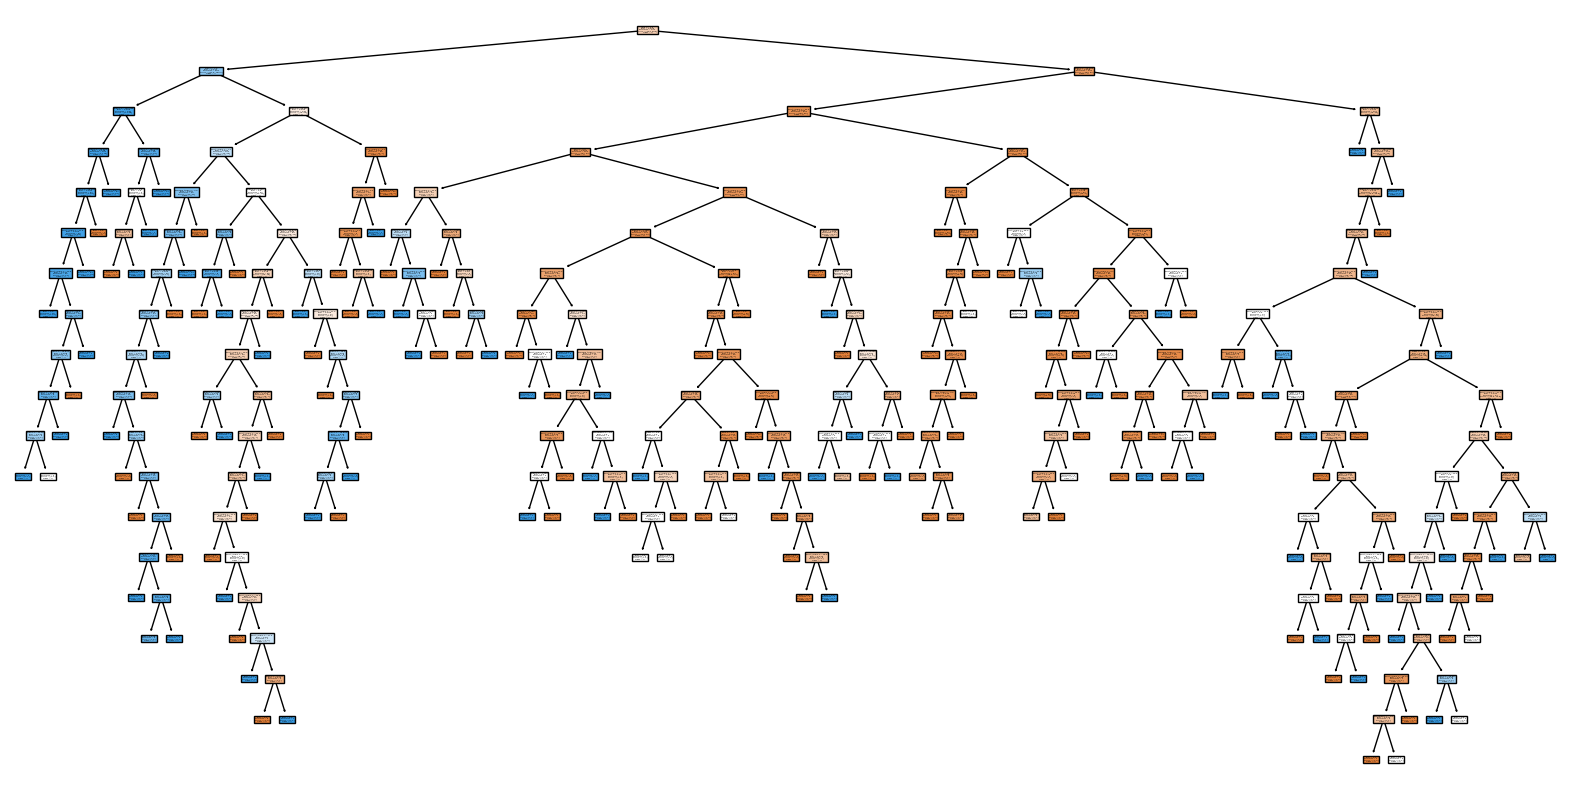

In [6]:
# Plot the decision tree
import matplotlib.pyplot as plt

def plot_decision_tree(model):
    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, feature_names=X_train.columns, class_names=y_train.astype(str).unique())
    plt.show()

plot_decision_tree(model_no_pruned)

In [ ]:
# Model Testing
from sklearn.metrics import f1_score

X_test = pd.DataFrame(preprocessing(X_test), columns = X_train.columns)
y_pred = model_no_pruned.predict(X_test)
f1_score(y_test, y_pred)

0.7083333333333334

In [8]:
# Pre Pruning
model_pre_pruned = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    max_leaf_nodes=20,
    class_weight='balanced',
    random_state=42,
    # min_impurity_decrease = 0.005 - carefully handle this hyperparameter
)

model_pre_pruned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', max_leaf_nodes=20,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

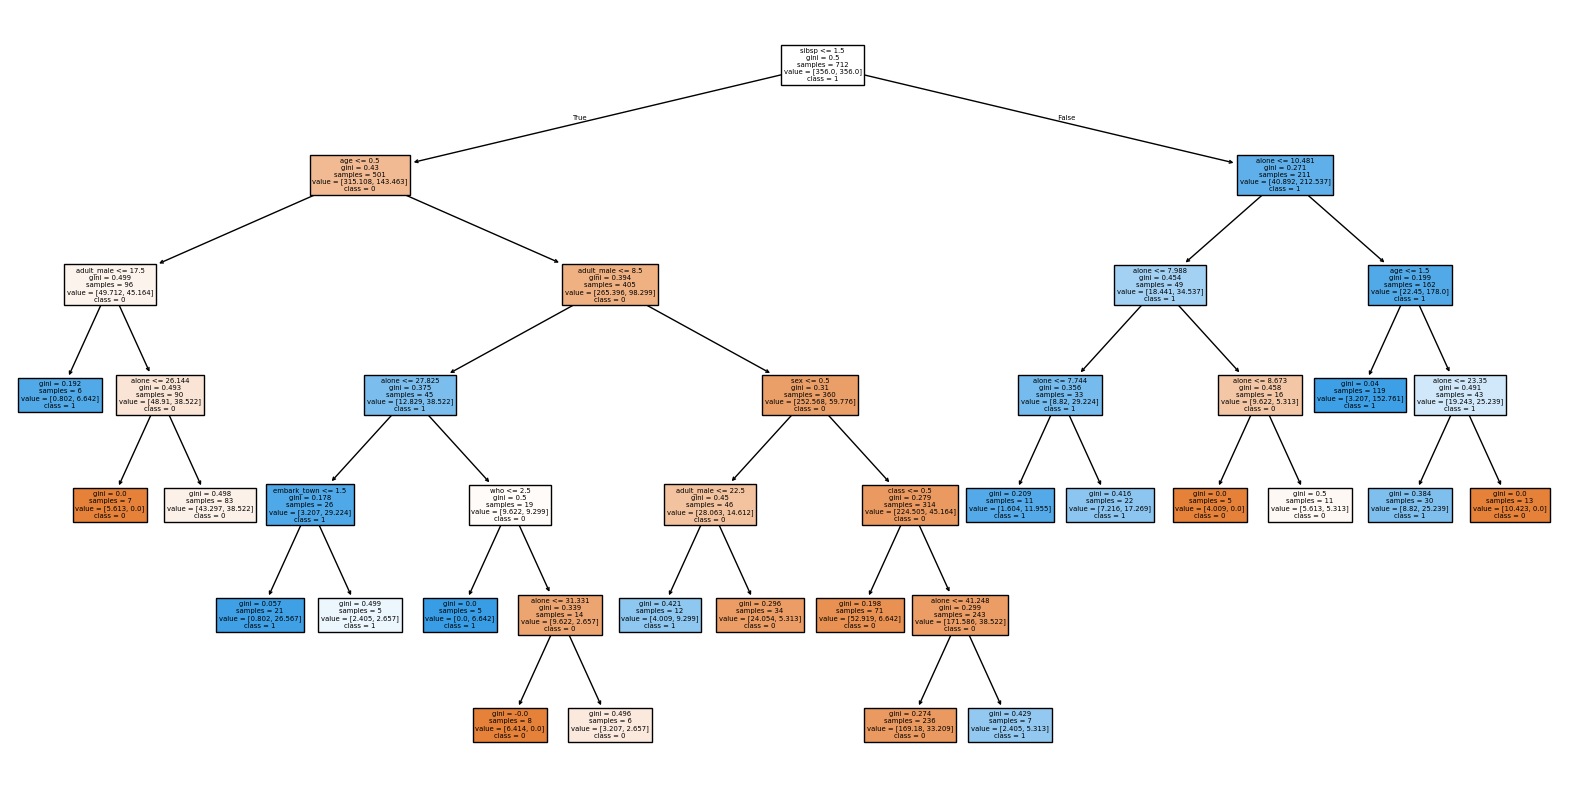

In [9]:
# Plot the decision tree
plot_decision_tree(model_pre_pruned)
plt.show()

In [ ]:
# Model Evaluation
y_pred = model_pre_pruned.predict(X_test)
f1_score(y_test, y_pred)

0.7375886524822695

In [10]:
# Post Pruning
model_post_pruned = DecisionTreeClassifier(
    ccp_alpha=0.005
)

model_post_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.005)

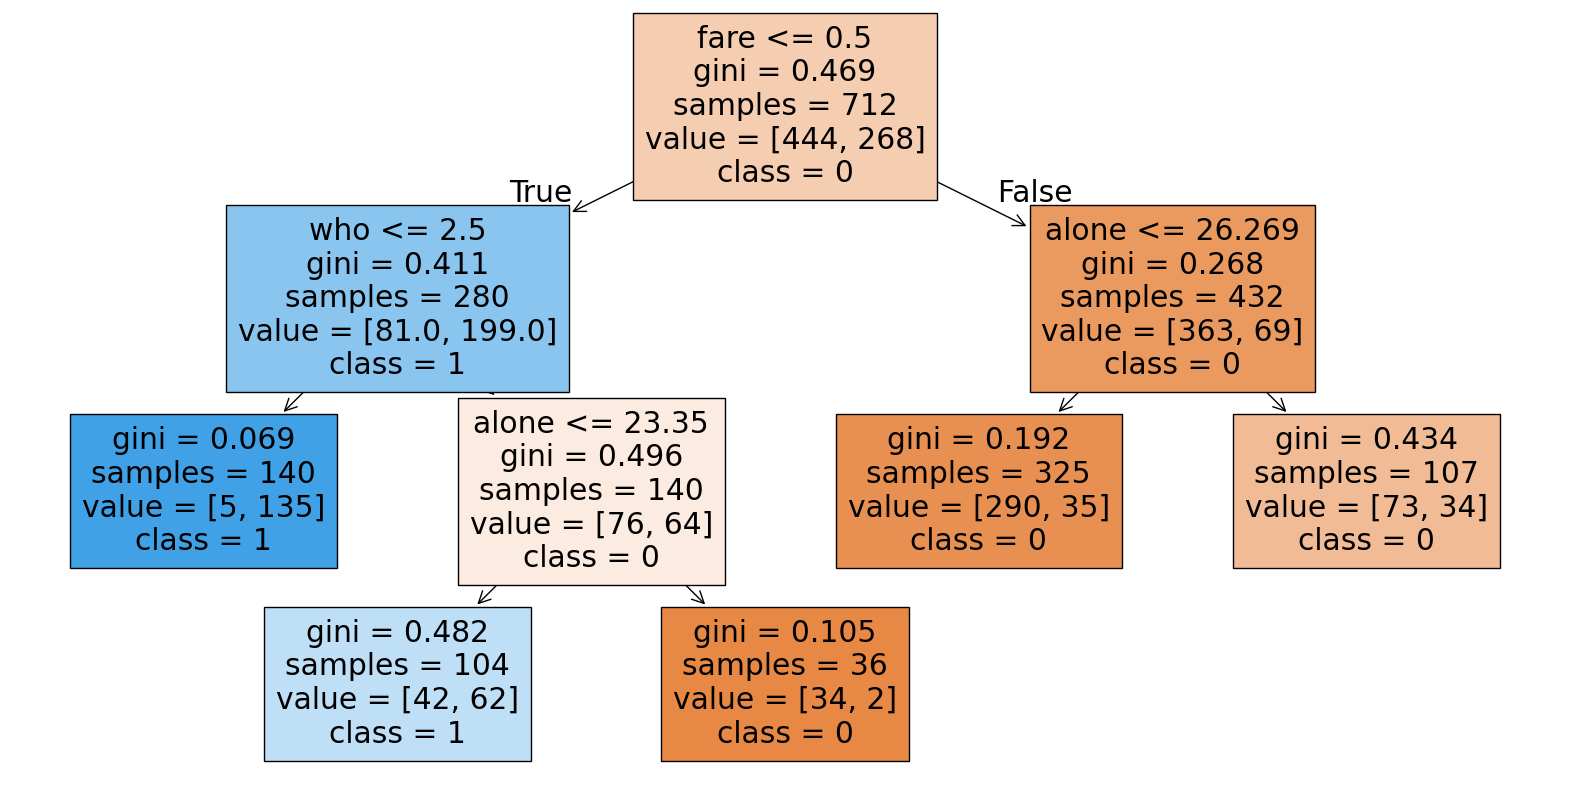

In [11]:
# Plot the decision tree
plot_decision_tree(model_post_pruned)

In [12]:
# Model Evaluation
y_pred = model_post_pruned.predict(X_test)
f1_score(y_test, y_pred)

0.7571428571428571

## How `min_weight_sample_leaf` hyperparameter helps `Tree Pruning`

### The Core Idea in One Sentence

`min_weight_fraction_leaf` is the **minimum fraction of the total "weight"** of all samples that must be in a leaf node. If a potential split would create a leaf with less than this fraction, the split is forbidden.

It's the **weighted version** of `min_samples_leaf`.

---

### 1. First, Understand "Weight"

Normally, every sample (row) in your data has a weight of `1`. So, the total weight is just the number of samples.
*   **With `min_samples_leaf=5`**, you're saying "every leaf must have at least 5 samples."

But sometimes, you give samples different weights using the `sample_weight` parameter. For example:
*   In a fraud dataset, you might give fraudulent transactions a weight of `10` and normal ones a weight of `1` because missing a fraud is costlier.
*   The **total weight** of your dataset is now `(number_of_normal * 1) + (number_of_fraud * 10)`.

### 2. How `min_weight_fraction_leaf` Works

This parameter is a **fraction** (a number between 0 and 0.5). Let's call it `M`.

**The Rule:** Any leaf node created by a split must have a **total weight of samples >= `M * Total_Weight_of_All_Samples`**.

#### Example 1: Default Behavior (No Custom Weights)

*   Your dataset has **100 samples**. Total weight = 100.
*   You set `min_weight_fraction_leaf = 0.05` (5%).
*   **Calculation:** `0.05 * 100 = 5`
*   **Interpretation:** This is exactly the same as setting `min_samples_leaf=5`. Every leaf must have at least 5 samples.

#### Example 2: With Custom Weights (Where It Shines)

*   Your dataset has **10 samples**.
    *   **9 "Normal”** transactions with weight = `1` each.
    *   **1 “Fraud”** transaction with weight = `10` (because it's very important).
*   **Total Weight** = (9 * 1) + (1 * 10) = `19`.
*   You set `min_weight_fraction_leaf = 0.1` (10%).
*   **Calculation:** `0.1 * 19 = 1.9`
*   **Interpretation:** Every leaf must have a total sample weight of **at least 1.9**.

Now, let's see what splits are allowed:

*   **A leaf with 1 "Normal" sample:** Total weight = `1`. **1 < 1.9` → Split FORBIDDEN.**
*   **A leaf with 2 "Normal" samples:** Total weight = `2`. **2 >= 1.9` → Split ALLOWED.**
*   **A leaf with 1 "Fraud" sample:** Total weight = `10`. **10 >= 1.9` → Split ALLOWED.**

This is powerful! The rule now intelligently understands that a single "Fraud" sample is 10x more important than a "Normal" sample and should be allowed to form its own leaf.

---

### Visual Analogy: The Grocery Store Checkout

Imagine your data is a line of customers at a grocery store.
*   **`min_samples_leaf`** is like saying: "Every checkout line must have at least 5 people."
*   **`min_weight_fraction_leaf`** is like saying: "Every checkout line must have at least $50 worth of groceries."

A person with a full cart ($200 of groceries) can checkout alone because they meet the $50 rule. But a person with just a candy bar ($1) must be grouped with others until their combined grocery total hits $50.

---

### Why Use It?

1.  **With `class_weight` or `sample_weight`**: This is its main purpose. It ensures the "importance" of samples is respected when controlling tree growth. You want to prevent leaves that are important (high weight) from being too small.
2.  **For Imbalanced Datasets**: If you use `class_weight='balanced'`, the classes are automatically weighted. Using `min_weight_fraction_leaf` ensures the tree-building process respects those weights.
3.  **Finer Control**: It can give you more nuanced control over the tree size than `min_samples_leaf` when your samples aren't all equally important.

### Summary

| Parameter | Focuses On... | Best For... |
| :--- | :--- | :--- |
| **`min_samples_leaf`** | **Number of samples** in a leaf. | Standard datasets where all samples are equally important. |
| **`min_weight_fraction_leaf`** | **Total weight of samples** in a leaf. | Datasets where some samples or classes are more important than others (using `sample_weight` or `class_weight`). |

**In short:** If you aren't using sample weights, `min_weight_fraction_leaf=0.0` (the default) is fine. If you are using weights, it's a crucial tool for building a better, more respectful tree.